In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
from scipy.io import wavfile
from glob import glob
from sklearn.model_selection import train_test_split

In [11]:
# Directorio donde se encuentra el conjunto de datos speech_commands
data_dir = '/Users/andavaro/Desktop/Andrès/UBA/TrabajoDeGradoCEIA/VENV_Python/Tesis_IA/data/mini_speech_commands'

In [12]:
# Lista de palabras a clasificar (ajusta esta lista según las palabras que quieras incluir)
labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

In [15]:
# Función para cargar los archivos de audio y convertirlos en características utilizables
def load_audio(file_path):
    _, audio = wavfile.read(file_path)
    #print('audio_0: ',len(audio))
    return audio.astype(np.float32)

def preprocess_data(data_dir, labels):
    X, y = [], []
    cont=0
    for label_index, label in enumerate(labels):
        # Buscar todos los archivos de audio para la etiqueta específica
        file_paths = glob(os.path.join(data_dir, label, '*.wav'))
        
        # Cargar y preprocesar cada archivo de audio
        for file_path in file_paths:
            audio = load_audio(file_path)
            #print('audio32: ',len(audio))
            if len(audio)== 16000:
                cont=cont+1

                X.append(audio)            
                y.append(label_index)
    #print('X; ',X)
    #print('y: ',y)
    #print('Diferentes: ',cont)
    
    return np.array(X), np.array(y)

In [16]:
# Cargar y preprocesar los datos
X, y = preprocess_data(data_dir, labels)

In [29]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Convertir las etiquetas en codificación one-hot
y_train = to_categorical(y_train, len(labels))
y_test = to_categorical(y_test, len(labels))

In [19]:
# Normalizar los datos (opcional pero recomendado)
X_train /= 255.0
X_test /= 255.0

In [ ]:
# Agregar aumento de datos para aumentar el tamaño del conjunto de entrenamiento
'''
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train[:, :, np.newaxis])
'''

In [22]:
# Crear el modelo CNN más profundo
model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(256, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(512, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels), activation='softmax')
])

2023-07-25 17:16:29.724782: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-25 17:16:29.724821: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-25 17:16:29.724827: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-25 17:16:29.724877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-25 17:16:29.724902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Utilizar callbacks para mejorar el entrenamiento
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
# Entrenar el modelo
history = model.fit(X_train[:, :, np.newaxis], y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

'''
# Entrenar el modelo con aumento de datos
model.fit(model.fit(X_train[:, :, np.newaxis], y_train, batch_size=32), 
          steps_per_epoch=len(X_train) / 32, epochs=10, 
          validation_data=(X_test[:, :, np.newaxis], y_test),
          callbacks=[early_stopping])
'''

Epoch 1/10
144/144 [==============================] - ETA: 0s - loss: 1.9474 - accuracy: 0.2822

2023-07-25 17:25:35.491133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 124s 862ms/step - loss: 1.9474 - accuracy: 0.2822 - val_loss: 1.7507 - val_accuracy: 0.2489
Epoch 2/10
144/144 [==============================] - 123s 853ms/step - loss: 1.9930 - accuracy: 0.3298 - val_loss: 1.6789 - val_accuracy: 0.3403
Epoch 3/10
144/144 [==============================] - 122s 848ms/step - loss: 2.4914 - accuracy: 0.3203 - val_loss: 3.4018 - val_accuracy: 0.3159
Epoch 4/10
144/144 [==============================] - 122s 849ms/step - loss: 5.4719 - accuracy: 0.3137 - val_loss: 10.3060 - val_accuracy: 0.2306
Epoch 5/10
144/144 [==============================] - 122s 849ms/step - loss: 101.3671 - accuracy: 0.2641 - val_loss: 493.6064 - val_accuracy: 0.2959
Epoch 6/10
144/144 [==============================] - 122s 849ms/step - loss: 31184.0840 - accuracy: 0.2597 - val_loss: 86487.2344 - val_accuracy: 0.2855
Epoch 7/10
144/144 [==============================] - 122s 850ms/step - loss: 1043719.5625 - accuracy: 0.2521 - val_loss: 

'\n# Entrenar el modelo con aumento de datos\nmodel.fit(model.fit(X_train[:, :, np.newaxis], y_train, batch_size=32), \n          steps_per_epoch=len(X_train) / 32, epochs=10, \n          validation_data=(X_test[:, :, np.newaxis], y_test),\n          callbacks=[early_stopping])\n'

In [27]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test[:, :, np.newaxis], y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

45/45 [==============================] - 12s 256ms/step - loss: 1.6342 - accuracy: 0.3684
Loss: 1.6342499256134033, Accuracy: 0.36838439106941223


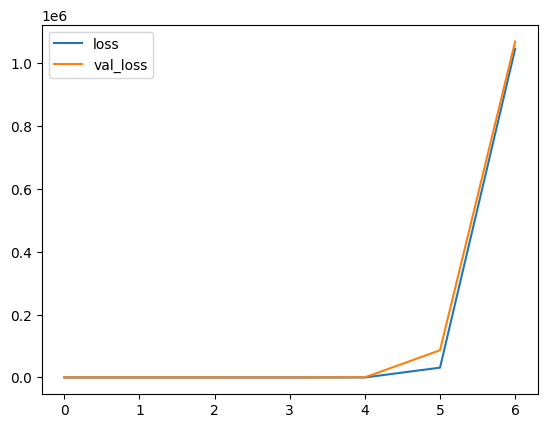

In [28]:
import matplotlib.pyplot as plt

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [30]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

 1/45 [..............................] - ETA: 5s

2023-07-25 17:41:11.444757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - 12s 262ms/step
Test set accuracy: 37%


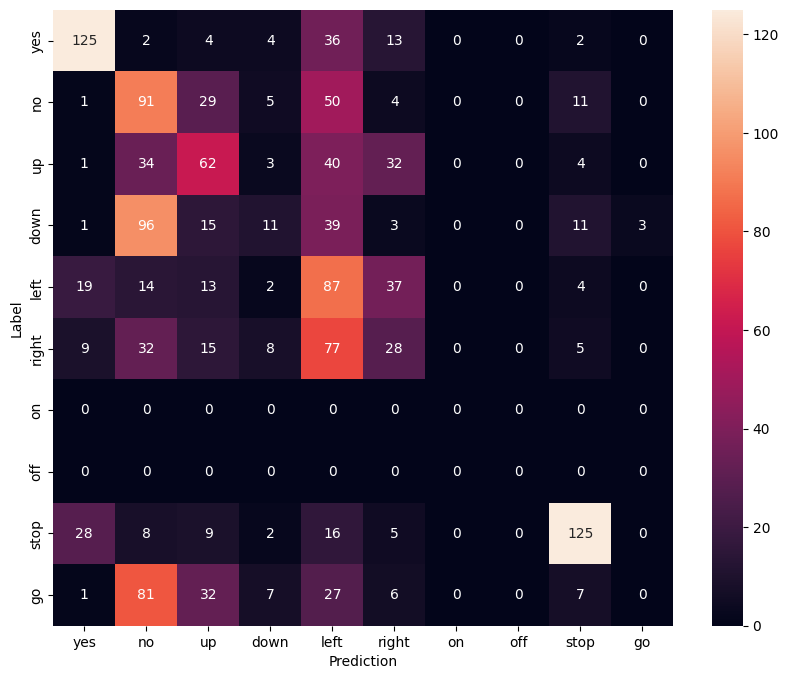

In [31]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()